In [35]:
# from google.colab import drive
# drive.mount('/content/drive')

In [36]:
import tensorflow as tf     ##tensorflow-gpu
import cv2                  ##opencv-python
import os
import matplotlib.pyplot as plt  ## matplotlib
import numpy as np
from google.colab.patches import cv2_imshow

In [37]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found. Make sure you have enabled the GPU runtime.')
else:
    print('GPU device found:', device_name)

GPU device found: /device:GPU:0


In [38]:
def resize_with_padding(image, target_size, padding_color=(0, 0, 0)):
    try:
        height, width = image.shape[:2]
        target_height, target_width = target_size
        aspect_ratio = width / height
        target_aspect_ratio = target_width / target_height
        if target_aspect_ratio > aspect_ratio:
            new_width = int(target_height * aspect_ratio)
            new_height = target_height
            pad_left = (target_width - new_width) // 2
            pad_right = target_width - new_width - pad_left
            pad_top = 0
            pad_bottom = 0
        else:
            new_width = target_width
            new_height = int(target_width / aspect_ratio)
            pad_left = 0
            pad_right = 0
            pad_top = (target_height - new_height) // 2
            pad_bottom = target_height - new_height - pad_top
        resized_image = cv2.resize(image, (new_width, new_height))
        padded_image = np.full((target_height, target_width, 3), padding_color, dtype=np.uint8)
        padded_image[pad_top:pad_top+new_height, pad_left:pad_left+new_width] = resized_image
        return padded_image
    except Exception as e:
        print("An error occurred during image resizing:", str(e))
        return None


.........1_Step...............


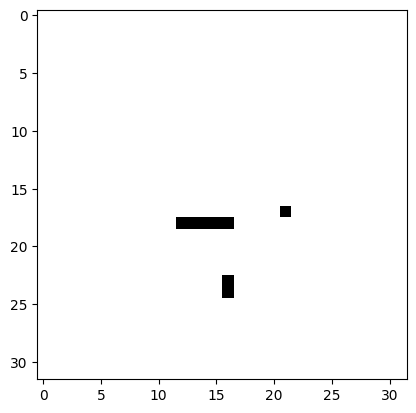

.........2_Step...............
Resize_image


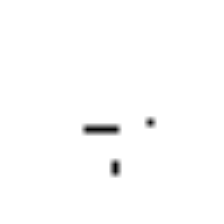

In [39]:
train_data= r'/content/drive/MyDrive/2 ba'
Classes = ['2.1' ,'2.2','2.3','2.4','2.5' ]
print(".........1_Step...............")
for category in Classes :
    path=os.path.join(train_data,category)
    for img in os.listdir(path):
       img_array=cv2.imread(os.path.join(path,img))
       backtorgb = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
       plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
       plt.show()
       break
    break
print(".........2_Step...............")
print("Resize_image")
img_size= 224 # ImageNet=>224*224
new_array = resize_with_padding(img_array, (224, 224), padding_color=(255, 255, 255))  # Resize the image with padding and set padding color to white
cv2_imshow(new_array)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [40]:
print("new_array",new_array.shape)
print("old_array")
img_array.shape

new_array (224, 224, 3)
old_array


(32, 32, 3)

In [41]:
print(".........3_Step...............")
print("reading all the images and converting them to arrays")
import os
import cv2
import random
import numpy as np
training_Data = []  # data
labels = []  # labels
def create_training_Data():
    for category in Classes:
        path = os.path.join(train_data, category)
        class_num = Classes.index(category)  # label
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_Data.append(new_array)
                labels.append(class_num)
            except Exception as e:
                pass

print("training_Data")
create_training_Data()
print(len(training_Data))
temp = np.array(training_Data)
print(temp.shape)
combined_data = list(zip(training_Data, labels))
random.shuffle(combined_data)
X = []  # data/feature
Y = []  # label
for features, label in combined_data:
    X.append(features)
    Y.append(label)
print("converting it to 4 dimensions")
X = np.array(X).reshape(-1, img_size, img_size, 3)  # converting it to 4 dimensions
print(X.shape)

.........3_Step...............
reading all the images and converting them to arrays
training_Data
1500
(1500, 224, 224, 3)
converting it to 4 dimensions
(1500, 224, 224, 3)


In [42]:
print(".........4_Step...............")
print("normalize the data")
X=X/255.0;  #we ara normalizrd it
Y=np.array(Y)
Y.shape
X.shape

.........4_Step...............
normalize the data


(1500, 224, 224, 3)

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=12)
print(X_train.shape)

(1350, 224, 224, 3)


In [44]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Assuming your training labels are stored in a list or array called 'train_labels'
train_labels = ['ba_iso','ba_first','ba_mid','ba_end']
# # Convert the labels to numerical format

label_mapping = {'ba_iso':0,'ba_first':1,'ba_mid':2,'ba_end':3  }

train_labels = [label_mapping[label] for label in train_labels]

# Convert the numerical labels to one-hot encoding
num_classes = len(label_mapping)
train_labels = to_categorical(train_labels, num_classes=num_classes)

# The train_labels variable is now ready to be used in model training
train_labels = np.repeat(train_labels, repeats=(len(X_train) // len(train_labels)), axis=0)
train_labels = np.concatenate((train_labels, train_labels[:len(X_train) % len(train_labels)]), axis=0)

In [45]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D , Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

num_classes = 5
# Load the MobileNet model without the top classification layer
model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the initial layers of the base model
for layer in model.layers[:100]:
    layer.trainable = True

# Add your custom layers for classification
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=model.input, outputs=predictions)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.1
)
train_generator = train_datagen.flow(X_train, train_labels, batch_size=32)

# Compile the model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=3)

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model with fine-tuning

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Train the model
y_train_categorical = to_categorical(y_train, num_classes=5)

# Train the model with fine-tuning
history=model.fit(X_train,y_train_categorical, epochs=65,  callbacks=[lr_scheduler, early_stopping])


Epoch 1/65
43/43 ━━━━━━━━━━━━━━━━━━━━ 43s 429ms/step - accuracy: 0.5613 - loss: 1.1190 - learning_rate: 1.0000e-04
Epoch 2/65
 1/43 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.9375 - loss: 0.2109

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9423 - loss: 0.2275 - learning_rate: 1.0000e-04
Epoch 3/65
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9639 - loss: 0.1141 - learning_rate: 1.0000e-04
Epoch 4/65
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.9881 - loss: 0.0509 - learning_rate: 1.0000e-04
Epoch 5/65
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9959 - loss: 0.0374 - learning_rate: 1.0000e-04
Epoch 6/65
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9981 - loss: 0.0217 - learning_rate: 1.0000e-04
Epoch 7/65
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9956 - loss: 0.0241 - learning_rate: 1.0000e-04
Epoch 8/65
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9965 - loss: 0.0207 - learning_rate: 1.0000e-04
Epoch 9/65
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9943 - loss: 0.0231 - learning_rate: 1.0000e-04
Epoch 10/65
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9988 - loss: 0.0110 - learning_rate: 1.0

In [54]:
model.save('ba_state_error.h5')
model=tf.keras.models.load_model('ba_state_error.h5')

In [55]:
y_test_categorical = to_categorical(y_test, num_classes=5)

loss, accuracy=model.evaluate(X_test,y_test_categorical)
print("accuracy=",accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - accuracy: 0.9847 - loss: 0.0703
accuracy= 0.9800000190734863


In [56]:
SIZE=256
n_model=tf.keras.models.load_model('/content/ba_state_error.h5')

.........8_Step...............
list all data in history
.........9_Step...............
dict_keys(['accuracy', 'loss', 'learning_rate'])


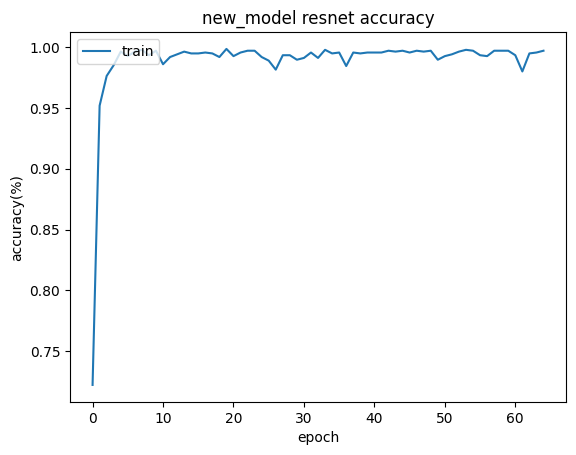

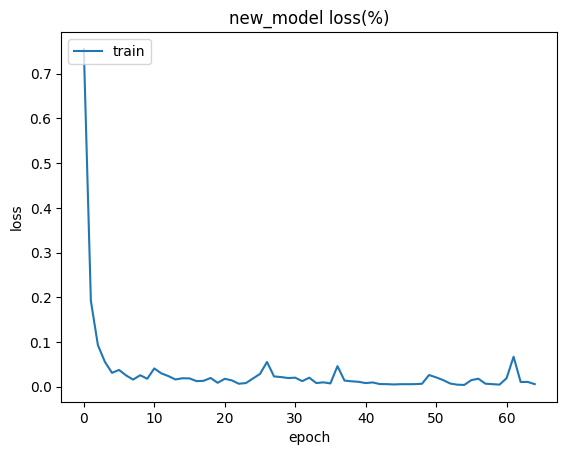

In [57]:
print(".........8_Step...............")
print("list all data in history")
import matplotlib.pyplot as plt
from tensorflow.python.lib.io import file_io
%matplotlib inline
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from sklearn.metrics import *
import skimage
from skimage.transform import rescale, resize
import pydot
print(".........9_Step...............")
# list all data in history",
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('new_model resnet accuracy')
plt.ylabel('accuracy(%)')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
 #summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('new_model loss(%)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [59]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
# Load and preprocess the image
img_path = '/content/ba.png'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = preprocess_input(x)
x = tf.expand_dims(x, axis=0)

# Perform image prediction
new_x = resize_with_padding(x, (256, 256), padding_color=(255, 255, 255))  # Resize the image with padding and set padding color to white
new_x = preprocess_input(new_x)
new_x = tf.expand_dims(x, axis=0)
preds = model.predict(x)
print(preds)

An error occurred during image resizing: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[2.3852404e-02 7.6893682e-04 1.4107300e-04 2.0974578e-02 9.5426297e-01]]


.........10_Step...............
.........Test dataset ...............
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step


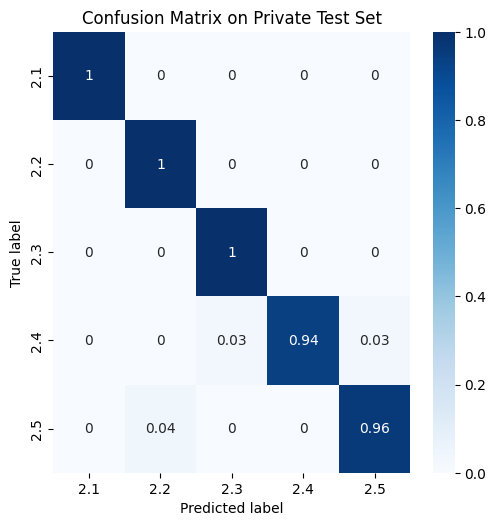

 Finding Accuracy, precision and recall
Accuracy   : 0.98
Precision : 0.9804647435897437
Recall    : 0.98
F1-score  : 0.9799032157665933


In [60]:
print(".........10_Step...............")
print(".........Test dataset ...............")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.lib.io import file_io

import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from seaborn import heatmap

charr = {0:'2.1', 1:'2.2', 2:'2.3',3:'2.4',4:'2.5'}
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test

cmat_df_test=pd.DataFrame(
  confusion_matrix(y_true, y_pred, normalize='true').round(2),
  index=charr.values(),
  columns=charr.values()
  )
plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on Private Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(" Finding Accuracy, precision and recall")
# Finding precision and recall
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy   :", accuracy)
precision = precision_score(y_test, y_pred,average="weighted")
print("Precision :", precision)
recall = recall_score(y_test, y_pred,average="weighted")
print("Recall    :", recall)
F1_score = f1_score(y_test, y_pred,average="weighted")
print("F1-score  :", F1_score)

.........12_Step...............
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
The prediction for this image is:  [1.3504551e-05 1.1066957e-06 9.8459809e-09 1.7473502e-07 9.9998522e-01]
The actual label for this image is:  4


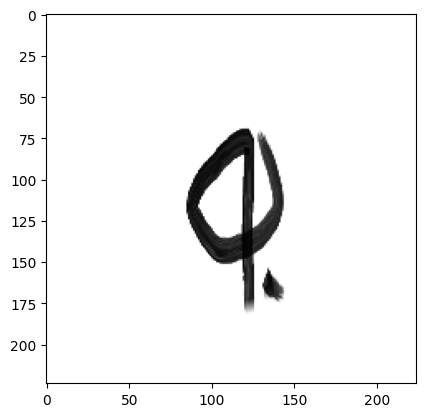

In [52]:
print(".........12_Step...............")
from sklearn.preprocessing import LabelEncoder
#Check results on a few select images
n=np.random.randint(0, X_test.shape[0])
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img = np.reshape(input_img, (224, 224, 3))
input_img = np.expand_dims(input_img, axis=0)
input_img_feature=model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = model.predict(input_img)[0]
le = LabelEncoder()
# prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", y_test[n])

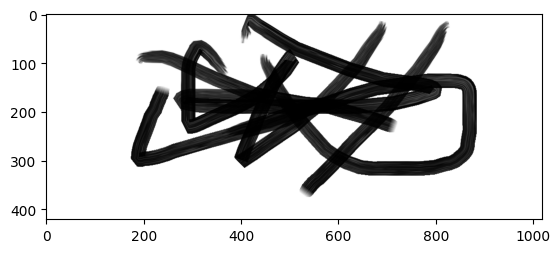

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The prediction for this image is: 4


In [66]:
from sklearn.preprocessing import LabelEncoder
import cv2
# Provide the file path of the image
img_path = '/content/asd.png'

# Read the image using OpenCV
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img)
plt.show()

# Preprocess the image for prediction
input_img = cv2.resize(img, (224, 224))  # Resize the image to match the input size of the model
input_img = np.expand_dims(input_img, axis=0)  # Expand dims so the input is (num images, x, y, c)
input_img = input_img / 255.0  # Normalize the image pixels to the range [0, 1]

# Make the prediction
input_img_feature = model.predict(input_img)
input_img_features = input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = model.predict(input_img)[0]

# Fit the LabelEncoder with training labels
le = LabelEncoder()
le.fit(y_train)

# Reverse the label encoding to get the original class name
prediction = le.inverse_transform([np.argmax(prediction)])[0]
print("The prediction for this image is:", prediction)
